# Time Series with Python

This notebook covers the core techniques necessary to manipulate, interpret, and extract insights from time series data, predicting time series data using statistical and machine learning models.

## Table of Contents

- [Introduction](#intro)
- [Merging Time Series With Different Dates](#s2)
- [Correlation of Two Time Series](#s3)
- [Spurious Correlation](#s4)
- [Simple Linear Regression](#s5)
- [Autocorrelation](#s6)
- [Taxing Exercise: Compute the ACF](#7)

---
<a id='intro'></a>

# Introduction

From stock prices to climate data, time series data are found in a wide variety of domains, and being able to effectively work with such data is an increasingly important skill for data scientists. This notebook will introduce you to **time series analysis in Python**. After learning about what a time series is, you'll learn about several time series models ranging from autoregressive and moving average models to cointegration models. Along the way, you'll learn how to estimate, forecast, and simulate these models using statistical libraries in Python. You'll see numerous examples of how these models are used, with a particular emphasis on applications in finance.

`Time series analysis deals with data which is ordere in time.`

- Trend
- Seasonality pattern
- Slice by year
- Sample, resample data
- Gradual decrease in something
- Spike

`A first step when analyzing a time series is to visualize the data with a plot`. You should be able to clearly see a gradual decrease in searches for "diet" throughout the calendar year, hitting a low around the December holidays, followed by a spike in searches around the new year as people make New Year's resolutions to lose weight.

Like many time series datasets you will be working with, `the index of dates are strings and should be converted to a datetime index before plotting`.

In [32]:
# Import pandas and plotting modules
import pandas as pd
import matplotlib.pyplot as plt

path = "data/dc26/"

In [33]:
df = pd.read_csv(path+'diet.csv', index_col='Date')
df.head()

,diet
Date,
6/26/2011,70
7/3/2011,71
7/10/2011,73
7/17/2011,74
7/24/2011,72


In [34]:
# Convert the date index to datetime
df.index = pd.to_datetime(df.index)

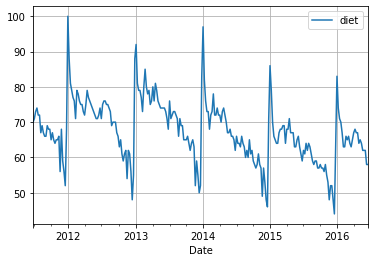

In [35]:
# Plot the entire time series diet and show gridlines
df.plot(grid=True)
plt.show();

In [36]:
df.head()

,diet
Date,
2011-06-26,70
2011-07-03,71
2011-07-10,73
2011-07-17,74
2011-07-24,72


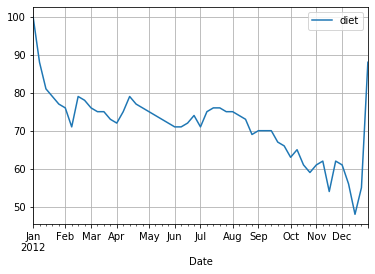

In [37]:
# Slice the dataset to keep only 2012
diet2012 = df['2012']

# Plot 2012 data
diet2012.plot(grid=True)
plt.show();

---
<a id='s2'></a>

## Merging Time Series With Different Dates

Stock and bond markets in the U.S. are closed on different days. For example, although the bond market is closed on Columbus Day (around Oct 12) and Veterans Day (around Nov 11), the stock market is open on those days. One way to see the dates that the stock market is open and the bond market is closed is to convert both indexes of dates into sets and take the difference in sets.

The pandas `.join()` method is a convenient tool to merge the stock and bond DataFrames on dates when both markets are open.

In [7]:
stocks = pd.read_csv(path+'stocks.csv', index_col='observation_date', parse_dates=True)
stocks.head()

,SP500
observation_date,
2007-06-11,1509.12
2007-06-12,1493.00
2007-06-13,1515.67
2007-06-14,1522.97
2007-06-15,1532.91


In [8]:
stocks.index

DatetimeIndex(['2007-06-11', '2007-06-12', '2007-06-13', '2007-06-14',
               '2007-06-15', '2007-06-18', '2007-06-19', '2007-06-20',
               '2007-06-21', '2007-06-22',
               ...
               '2017-05-26', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09'],
              dtype='datetime64[ns]', name='observation_date', length=2519, freq=None)

In [9]:
bonds = pd.read_csv(path+'bonds.csv', index_col='observation_date', parse_dates=True)
bonds.head()

,US10Y
observation_date,
2007-06-08,5.12
2007-06-11,5.14
2007-06-12,5.26
2007-06-13,5.20
2007-06-14,5.23


In [10]:
# Convert the stock index and bond index into sets
set_stock_dates = set(stocks.index)
set_bond_dates = set(bonds.index)

#set_stock_dates

In [11]:
# Take the difference between the sets and print
print(set_stock_dates - set_bond_dates)

# Merge stocks and bonds DataFrames using inner join()
#  to get intersection of dates
stocks_and_bonds = stocks.join(bonds, how='inner')

{Timestamp('2010-11-11 00:00:00'), Timestamp('2013-11-11 00:00:00'), Timestamp('2016-11-11 00:00:00'), Timestamp('2012-10-08 00:00:00'), Timestamp('2011-11-11 00:00:00'), Timestamp('2009-10-12 00:00:00'), Timestamp('2007-10-08 00:00:00'), Timestamp('2016-10-10 00:00:00'), Timestamp('2017-06-09 00:00:00'), Timestamp('2014-10-13 00:00:00'), Timestamp('2008-10-13 00:00:00'), Timestamp('2014-11-11 00:00:00'), Timestamp('2009-11-11 00:00:00'), Timestamp('2008-11-11 00:00:00'), Timestamp('2015-10-12 00:00:00'), Timestamp('2011-10-10 00:00:00'), Timestamp('2007-11-12 00:00:00'), Timestamp('2013-10-14 00:00:00'), Timestamp('2010-10-11 00:00:00'), Timestamp('2012-11-12 00:00:00'), Timestamp('2015-11-11 00:00:00')}


In [12]:
stocks_and_bonds

,SP500,US10Y
observation_date,,
2007-06-11,1509.12,5.14
2007-06-12,1493.00,5.26
2007-06-13,1515.67,5.20
2007-06-14,1522.97,5.23
2007-06-15,1532.91,5.16
...,...,...
2017-06-02,2439.07,2.15
2017-06-05,2436.10,2.18
2017-06-06,2429.33,2.14


---
<a id='s3'></a>

## Correlation of Two Time Series (Stocks and Bonds)

Investors are often interested in the correlation between the returns of two different assets for asset allocation and hedging purposes. In this exercise, you'll try to answer the question of whether stocks are positively or negatively correlated with bonds. Scatter plots are also useful for visualizing the correlation between the two variables.

Keep in mind that `you should compute the correlations on the percentage changes rather than the levels`.

In [13]:
# Compute percent change using pct_change()
returns = stocks_and_bonds.pct_change()

returns.head()

,SP500,US10Y
observation_date,,
2007-06-11,NaN,NaN
2007-06-12,-0.010682,0.023346
2007-06-13,0.015184,-0.011407
2007-06-14,0.004816,0.005769
2007-06-15,0.006527,-0.013384


In [14]:
# Compute correlation using corr()
correlation = returns.SP500.corr(returns.US10Y)
print("Correlation of stocks and interest rates: ", correlation)

Correlation of stocks and interest rates:  0.4119448886249272


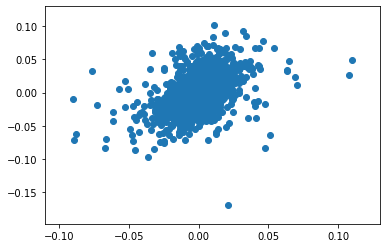

In [15]:
# Make scatter plot
plt.scatter(returns.SP500, returns.US10Y)
plt.show();

The positive correlation means that when interest rates go down, stock prices go down. For example, during crises like 9/11, investors sold stocks and moved their money to less risky bonds (this is sometimes referred to as a 'flight to quality'). During these periods, stocks drop and interest rates drop as well. Of course, there are times when the opposite relationship holds too.

---
<a id='s4'></a>

## Spurious Correlation - Flying Saucers Aren't Correlated to Flying Markets

Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as **"spurious correlation"**. That's why when you look at the correlation of say, two stocks, `you should look at the correlation of their returns and not their levels`.

<img src="images/ts_001.svg" alt="" style="width: 400px;"/>

To illustrate this point, calculate the correlation between the levels of the stock market and the annual sightings of UFOs. Both of those time series have trended up over the last several decades, and the correlation of their levels is very high. Then calculate the correlation of their percent changes. This will be close to zero, since there is no relationship between those two series.

In [18]:
df = pd.read_csv(path+'levels.csv', index_col='Date', parse_dates=True)
df.head()

,DJI,UFO
Date,,
1941-01-01,110.96,1
1942-01-01,119.40,2
1943-01-01,135.89,9
1944-01-01,152.32,9
1945-01-01,192.91,9


In [21]:
# Compute correlation of df
levels = df.copy()
correlation1 = levels['DJI'].corr(levels['UFO'])
print("Correlation of levels: ", correlation1)

Correlation of levels:  0.9399762210726432


In [23]:
# Compute correlation of percent changes
changes = levels.pct_change()
changes.head()

,DJI,UFO
Date,,
1941-01-01,NaN,NaN
1942-01-01,0.076063,1.0
1943-01-01,0.138107,3.5
1944-01-01,0.120907,0.0
1945-01-01,0.266478,0.0


In [24]:
correlation2 = changes['DJI'].corr(changes['UFO'])
print("Correlation of changes: ", correlation2)

Correlation of changes:  0.06026935462405376


---
<a id='s5'></a>

## Simple Linear Regression - Looking at a Regression's R-Squared

**R-squared** measures how closely the data fit the regression line, so the **R-squared** in a simple regression `is related to the correlation between the two variables`. In particular, the magnitude of the correlation is the square root of the **R-squared** and the sign of the correlation is the sign of the regression coefficient.

In this exercise, you will start using the statistical package `statsmodels`, which performs much of the statistical modeling and testing that is found in R and software packages like SAS and MATLAB.

You will take two series, `x` and `y`, compute their correlation, and then regress `y` on `x` using the function `OLS(y,x)` in the `statsmodels.api` library (note that the dependent, or right-hand side variable y is the first argument). Most linear regressions contain a constant term which is the `intercept` (the α in the regression yt=α+βxt+ϵt). To include a constant using the function `OLS()`, you need to add a column of 1's to the right hand side of the regression.

In [26]:
x = pd.Series([1.2811550440412238, -0.6126310598985145, 0.9332222021268057, 2.2693265731638363, -1.427691082555, 0.6405188010777155, -1.596489626936219, 0.33561618750787203, -1.661094450815615, -0.892276781318839, -0.3853601714404014, 1.1750613930276552, 1.0795261289242912, -1.2035994956420473, -0.056172151726598965, -0.3766366045789261, 1.5701795772212934, -0.9428046774925836, 0.15111742087150695, 0.9206869830404033, 0.39865553922740776, 0.509308881338481, -0.33266116373611765, -2.23945925855725, -0.4534897919461296, 1.0290382457244724, -1.8780126981110872, 0.21017468558027702, -0.4757487221856649, -1.2186501112582493, 0.9308799884171601, -0.6028764223428251, -1.2009086565864688, -0.0964592154016757, 1.212574421217251, -0.6424298804905836, -1.37811844503333, 2.3018322938539786, 0.3649715099125608, 0.45720613554168227, -1.3774898420827786, -1.4383766335317467, 0.063973133855837, 0.44278722045348, -1.9974962921111783, -1.4044702210471958, 0.08692671859178444, 0.5570923022590792, 0.7522245332145279, -0.4545804023390465, -1.0680666881208938, -0.11323127134326061, 0.031636849769069254, -0.5913536163273568, -0.7743368977153091, 0.6947645888461771, 0.8286835284249676, -0.924767578153199, 1.2618915478818902, -2.3626119374754966, 0.14534783815545224, 0.049616126607182204, -1.6283838027917457, -0.6800270946068546, -0.5884337805404406, 0.7260916073821183, 0.8092150965860476, -0.6693518909217461, 0.9388824358296493, -1.5595639187088612, 0.8316986060383421, -1.1608014157128452, -0.5898791339712739, -0.09934721933319744, 0.2656448155523166, -0.18394678158088928, 0.9564584613417034, 1.0313898667732246, -0.6584946536221273, -1.3743996656695014, -0.0631732256437111, 0.026892033235163947, -0.8496921931994855, -1.729939107593855, -0.13857788040834806, 1.005633140702026, 0.7383585048100306, -0.06374618401822056, -0.43627521742932374, 0.41300383170708127, 0.23527973389250745, -1.4402823175412254, -0.037024592454535196, 0.3163210863597245, 0.4334010006371085, -0.1794067693088721, -0.22272937057979608, -0.9145161654283759, 0.23768785153671315, 0.2838865108117988, -0.8192423257468685, -1.9910712050577701, -0.04006354807978106, -0.12033738970715552, 0.15510748588618137, -0.4352447189222036, -0.0487281261986246, 1.0126578930049703, -0.7907201580971653, 0.7428329253873476, 1.100457607102351, 0.15812950730365105, -1.2496169877073868, 0.5361294618762135, 1.233762471342156, 1.7284866572391626, 0.25594780064858513, -0.41149149785151656, -1.0497931002530645, -0.6235509427190559, -0.22097480931607114, -0.46150241750214294, -0.4961601004936394, -1.0958358832877453, 1.5092875490667619, -1.6290323928216552, 0.28681646837921426, -0.7418999422719599, -0.5499656749845604, 0.6326764122049733, -0.029633564332853045, -0.012109250331289711, -1.0441640436490787, -0.5562011045733684, -1.0941654365809972, 0.8860495062314049, -1.5088203163123568, 1.1374329048126899, -1.5501735403499899, 0.6954523634231947, 0.9546853946527298, 1.3765439821968224, 0.19330216840911907, 1.892079712068668, 1.3575960296100273, 1.1969930896344374, -1.1278705031605591, 2.03058893387105, -1.7353520911623042, 0.026824698899590858, -0.9310507631310321, 0.7791126068047515, 0.4347688092705445, 0.8543492855148576, -0.36223449264905516, -0.9940674283863438, 1.1226780657187447, -1.3693434103086404, 0.09262208932661621, 0.16669856561892382, 0.4959097730434428, 0.05771982648856984, -0.6053809875603205, 1.6330030670912459, 0.288167641685169, 0.5595427949202992, 0.49161723704835875, 0.03710723132111678, -0.017796291447584375, -1.6570629840076838, 0.3972959690857464, -0.9938556824225638, 1.8668058033948733, 0.07302987315908709, 1.398213208859564, 0.27355501335685684, 0.6690414670643127, 1.1038295883597358, 1.3931754019172784, 1.5883723046544935, 0.5418476161290624, 0.5544303328617051, 0.9750753573422007, -1.916275205762016, -0.3626735851149104, 2.0628270289912463, -1.0723062135838064, 1.3360361211494085, 0.5475010717195191, -0.617524225013694, -0.9951149589811019, 1.0753160668536368, 0.3617901279608233, 0.9195681367049232, -0.4004585726579531, -0.6068603367567185, 0.048114274223299905, 1.6377358736628664, 0.33899410124172297, 0.21872786133555278, -1.6137386502993685, 0.18580232306052935, 0.22686320183666522, 1.5578421135323661, 0.1550583148874443, -0.3003998683723746, 0.32638341890705735, -1.370763314129386, -0.7321718364215666, -0.029719106687211696, 1.7250975811712936, 0.4285524229951472, 0.2782490086843458, 0.21799582474990986, 0.6062628073626953, 1.4581079982282943, -0.42615886544821197, -0.613083279799305, -0.5239485031323156, -1.670621825863721, -1.2640011981364627, 0.4132286076001853, -1.0532361755894544, 1.2835926349746098, -1.5735587350796931, -0.4084227724876398, 1.224872313494202, 0.3415187228815285, 0.19644259010643528, 0.18081070948849623, 0.3623181904942318, 1.689157463781665, -0.9965124679839346, -0.8218393586151007, -0.7848407321055315, -0.3228685919425816, -0.7392740033123055, -0.1500074064532319, 0.8107759705086444, 2.084423434792031, 0.8834937342698636, 2.8462671773195503, -0.14121234494487378, -0.8049187751604127, -2.321357750576519, 1.4134332889826897, 0.7466704197993697, 1.1506086948952838, -0.5060139080093885, -0.3354555917233457, -0.7174196055120188, 0.46658579812084167, -0.9298327945813356, 0.8456943454100372, 1.6050684916244604, -0.4352825695391445, -1.9727099686582816, 1.1880683084519628, -0.02323359841623244, -0.24158816746740822, 1.9061970426288974, 0.49757036585345893, 0.5293471899531691, -0.8387104275950436, -0.5384323931023147, -0.7710273505799191, -0.4109576100166529, -0.5375557392726514, -1.5226691060085205, 0.14313515560202128, 0.7624238993783363, 0.7334933564387248, 0.6587312472188919, 2.3626061416920234, 0.3191632013596961, 0.04647159859516381, -0.2755369854000762, -1.2814167482484604, -1.0777145898391958, -0.9643591443282876, 0.15456707448551382, 1.437029181593196, -1.3800682370220185, 1.0731570224196485, -0.05897203935250225, -0.1439819613811889, -1.2485507089306842, -1.0057958766239532, 0.2789286444875427, -1.8381512357957208, 0.4710816881100636, -0.913624085432763, 0.9228774883219917, -0.5269972810731411, -0.27566919969978776, -2.4872289245654806, 0.1324871295970721, -0.10288181143216761, 0.3028590233167439, -1.1743571235057015, -1.2880133585328295, -0.3417605743186503, -1.077587395061371, -2.151807645950538, -0.3927978678746878, 0.08400358092594723, -0.8270919285328677, -0.6129373404939361, 0.6952301625622106, 0.5021781114624926, 0.1799869140519854, -0.6192803879513986, 0.00587192506491817, 0.594271575339764, 0.5897645313049396, 0.5922167751763496, 2.134722295912065, 1.3347873183650223, -1.486619153082548, 0.08560166020524435, -1.6925581993269394, 1.011708416153619, -0.14020801309204117, 0.48184848501024724, 0.6718729525263696, -1.127862151776186, -0.2990782844837448, -0.7975916684903256, -0.3975826691867548, 2.142217744330889, 1.4066085892138767, 0.5273293230858743, 0.1378760563116852, 0.532649039316254, -1.223478422259192, -0.10299034282643785, -1.2822830722842427, 0.1032967267630437, 1.928093739383223, -0.7740374677171789, -0.7438198607084211, -0.18269039221875313, 0.7846498395908826, -0.10984657843530585, -0.3863608426004779, 1.5077979737496812, 0.00482917034885061, 1.732017154629424, -1.2295623137610412, -0.5725147309505427, -0.24956431539792898, -1.487353180389997, 0.4174945289618317, -1.6923016399179027, -0.23941151210717423, 0.965475945065727, 0.5473140277406429, 0.2719169871221121, 0.6603713592024104, -0.25902229365406354, -0.7604130478169479, -1.0078748877980297, 0.7870183151313934, -0.21502826189311067, -0.17072095044503943, 1.0236868222160658, 0.37755614563511675, 2.6108068431657854, 0.5246756173219759, 0.4836598162210405, 0.26742536748967183, 0.0169831633554079, 0.4562201011537283, -0.6606608098771884, 0.9949365427832687, -1.226735600080754, -1.6380411876107703, 2.041699248954565, 0.33493880002694376, 0.4529649856245742, -1.5153549153241226, 1.0909300176620387, 2.4913638757172443, 2.10651569366746, 1.9351030231528283, -2.1958407413708603, -0.4138797661100451, 0.250136395904108, 1.592751568266953, -1.2389426603316052, -0.26438440815028813, 1.6003122903891118, 0.4369099686809913, 0.66219670316823, 1.1573741156588628, 1.4986431755506244, 1.3255114982392833, -0.17931322235265917, -1.1957287571528918, 0.533196745245951, -0.3310345732826881, 0.9349535940920656, 1.5696533587044477, -0.5976302756882733, 0.630972928035347, -0.8272691085540191, 1.7440692032035177, -1.0589381321382874, 0.49376280519717664, 1.0662321134033914, -1.1480332637032122, 0.3315584422919956, -0.3645639530891268, 1.3957648949802663, 1.4190645340791712, 0.7116013566560508, 0.14958564285001907, -0.8387551985432976, -1.2123958029963737, 0.12306868449402704, 0.019751710655750914, 1.047685567212333, 0.29271014402798606, 0.5786548342762493, 0.7047096725632085, -2.708538556470341, 0.05010884493866954, -0.2969818564128184, 0.3999492635439395, 1.7223695598737703, -0.586845060734203, -0.026973741469146, -1.4616921654481712, 0.138495855842951, -1.123850873579895, 0.017135589417939627, 0.09308131402918762, 1.1230826990102114, -0.20143798281762954, -0.7258410981859367, 0.24627241367922775, 1.1296361715909322, 0.058552159550198345, -1.7983273468722822, 2.210210728664325, 2.249115280136353e-05, -0.5984532062176234, -0.45670278983757234, 1.1603754016024759, -1.0449496803465854, -0.4435199490079035, -1.8261954122445656, 0.2584637202654191, -0.4083742936784235, 0.693394936295836, -0.17069021353895084, 0.5684291527085978, 0.6665539259234277, 0.7259434644264395, -0.7818996934482328, -0.5742831908261057, -1.0057955675400962, 0.2767666945183962, -0.02657171937867959, 1.4859056991110522, 1.1814689108569423, -0.3200975323792521, 0.2979647582167218, -0.3232515902839842, 0.5459492822819827, 2.9272109032239864, 0.8037546198436225, -0.7499979255776861, 1.0195486390030897, -0.19318912479046815, 0.5013507507734484, -0.3154248752490127, -0.6909048361483536, -0.162428172141605, 0.6619320564839841, 1.541660251566514, 0.24676306444895935, -0.6081792360254962, 0.2230484458049995, -0.19688612727743685, -2.0280595004339546, -0.2019706712044319, 0.15767319852175163, -0.09038685208329725, -1.2842696550826431, 0.27116452125930596, -0.7124928794583623, 0.017356569438715625, 1.1873032421525376, 1.7072145367579399, 0.6655242675765024, 0.8527135331212987, 0.5509525519030603, -1.2461593572236154, -0.7068798069098832, 0.8567847697718416, -0.9234348937646064, -0.8806828886735357, -0.05609809998169541, 0.5019083657396824, -0.4157581652339636, 0.7576816160052998, -0.2833796697872356, -2.2915502845187197, -0.09944721684838555, 0.3980119421690809, 0.09454416205183548, 0.14329540595075083, -0.8734928742311916, 0.7584630765437268, -0.7908212321453724, -0.4320523265745874, 0.37025365268475396, -1.062001122245369, -0.4828920876000209, 0.6936722586624583, 0.5858808880619747, 1.4508861702159925, 0.7500862350496543, 0.5420294884948335, 1.0398706462749154, -0.1948557651599005, -2.385752240649883, -0.47077742637789227, 2.064509427221515, -1.386038447705097, -0.21990377100261563, -0.22630975846881524, -0.2588868206001651, -1.2646588934123528, -1.0834969364983877, -1.401409873741469, -0.0792912256992738, -0.2639577678483505, 0.032443527882877736, -0.1958118189742201, -0.2696672440142078, 2.356910173616174, -0.6625621350495404, -0.9823303116647341, -0.23929616612266164, -0.34032350329971356, -0.057851705966839494, -0.30298116057390284, -0.6066365014043973, 0.9809215742936962, -0.6705935056817571, -0.17471250370687091, -0.5779101748507249, -1.452565538806313, -0.6818093230131186, -0.875640737584392, 1.0829587238449638, 1.8344569102333776, 1.7031903105405986, -1.5062289827032123, 0.17890924580770518, -0.8351542433791986, 0.2710173607705894, 0.31965118866128406, 0.07953331906928739, -0.8475414408512983, 0.24929629756979074, 0.2938749017440937, 0.8625826904665663, -0.11273579413889787, 2.8006286023584983, -0.1117548423137034, 0.39703141240929996, -1.521600652092554, -1.0163254285070924, -0.28332438531049664, 1.2965563661393242, -0.9501724981207302, 0.2289047380394984, -0.5596777441867471, 0.020094441466944817, 1.0979926410447785, -1.3706395935376305, 1.5666130505215872, -0.7501925731978024, 0.6444428853456805, 0.5117080499010401, 0.017447261865881667, 1.2959498184802178, -1.2468030429927888, -0.8573379299224981, 0.8039631360433173, 0.9543085510513728, -1.545932002127972, 0.9610860616851591, -1.958830433328374, -0.4483478967243869, -0.3776644755498551, 0.5354507909342476, -1.0430895803398843, -1.0779232456335477, 0.33595254329514174, -0.5436533946867769, -0.5306417023748377, 0.8078920393134098, -0.8419042600738254, -1.424370805760945, 1.0103737412666025, -1.9600896409016224, 1.0225799813611687, -0.3422881659706962, -0.6327289414396146, 0.5735534796741496, 1.4513051087363864, 0.6070670062511726, 0.8195271507826488, -0.8639349441826176, 0.969726864583193, -0.38714731089393417, -1.423694462749488, -0.24029038589401666, -0.4859663413673385, 0.7421587411711145, 0.8955230500216699, -1.1931899850241667, -0.5250812576299323, 0.21044349786095048, -1.0435990843554972, -0.3553472314138764, -0.5745147739830379, 0.7270555706490947, -0.69252072507968, 0.0824295389407393, 0.5676522158489848, 0.4926951570286256, 0.12162848455760715, -0.3325245708296114, -1.040665362591346, -0.15104187318030327, 0.8482850141165379, 0.7282104379946829, 1.623223724188598, 1.065346721644724, -0.4631233870124684, -0.561463658403215, 0.08141045468279497, -0.6033751809042917, -1.2494181168901144, -1.0226185527491465, 1.6672766121243676, 0.5161077828412061, 0.7303143773731128, -1.2042140822667036, 0.42095035407325243, -0.5998653289544662, 0.4730008839090102, -1.9236000119268668, -1.1632113128844814, -0.34857698511954055, 0.6361644542059346, -0.28998923755127615, 0.5156222422474026, -2.0302343228889934, -1.408920553545117, -0.7164483539762333, 0.53851393409135, 1.632852293911881, -0.7059173661787806, -1.292958091755332, 0.22475214833323107, -0.7183152270319154, -0.0016646080338889222, -0.8232330902111494, 0.651173508629377, -0.23430488957409498, 0.9596102360167784, 0.28027084053186496, -0.3071623437513136, -0.150701948491389, 0.26539723370731777, 0.6575421788781195, -2.356978810174661, -0.4189421126781944, 0.33527442916251604, -0.6961444008576461, 0.23852841584644008, -0.9148663907490183, -0.6938629955169826, -0.6512048216975727, -0.44042201807582315, 0.4538387099487502, -0.9022531905831274, -0.43919529829075504, -0.48533301832222464, 1.400748938049492, -0.3041538855755456, 0.8022650307410149, 0.14423517799219773, -0.6162872691345818, -0.9003867648716256, -0.6426862410461465, -0.6385018025685305, -0.27749862681611087, -0.8898549936931711, -0.4845848557476576, -0.7462569079316493, -0.6660847909048132, -1.061698323614797, -0.4595916991858538, -0.4964001994536581, -1.1517433065966902, -0.7147352986264145, -0.979615491705565, -2.0022433379234714, -0.7920934071778448, 0.28918556795146877, -0.14459509154605615, 0.6300675586142113, 0.09113513829642259, 1.6182337171766665, 0.697616497978575, 0.40845000090522027, 0.0392003485912506, 1.2886297909140367, -0.9013774801911525, -0.7218805040877588, -2.3364088265360605, -0.15122718168423352, 1.5917319487562862, 0.10945483690096314, -0.5218476396593968, 0.014770133898636802, 0.5219232582969562, -1.6651425334274597, -0.9810023979643574, -0.49861418819806225, -0.37784158380837596, -1.9509977835799683, -0.7596789412979185, 0.5756436940108495, -0.1263915844750892, -0.2881655458555227, -0.21126222635427996, 0.8763471869337076, -0.16128480613787813, -0.595613530727245, 0.8223961660652714, 1.3938876633750859, -0.08179642293560137, -1.1508612743295161, 0.45892509993606106, 1.4622506372355752, 1.4968046003337594, 0.4330563169849272, 0.08146859954689607, -0.23758794588910806, 0.14433456436630293, 1.4297074738636055, -0.11910530737610853, 0.24994708657435719, -1.5397817734025403, 0.4710670256217842, -0.7528800491508506, 1.4973821201153297, -0.7370596961142618, -0.36600088826730276, 1.0788087412974006, 1.1097788135373696, 0.5606108417697564, 1.5254143138934957, -0.9083822366856663, 1.4745649737166788, 1.0676285887446368, 0.2614622875043119, -0.761594329523209, 0.16746351806632892, 0.29831306786322237, -0.3868078445771079, -0.3281181510361313, -0.20920587718194528, -0.6971623037562072, 0.8201147170205032, 0.8068979989605962, -0.14410762019304135, -0.03255522222679558, -1.0687328094882182, -0.27438958461986906, -1.5786072326056277, 0.0031124932782617726, 3.0875196913749394, -0.36685895820665904, 0.29001956648771726, 1.3781054114403108, -0.9691407832538603, -0.2555576493873456, 0.8684177508230642, -0.5193399002961957, -1.3421682606120884, 0.3147406832043353, 0.772758949221254, 0.632743021432991, 0.6282855528469061, -0.294330104752678, -1.1039735835170281, 0.4838728779399808, 1.091109943724447, -0.11402960847367027, 0.7216136659581276, -0.7952585606905005, 1.2900928276303572, 0.668708214494058, 1.6316989496194068, 0.4674668654867797, -1.4593356445396, 0.39301110318936955, -1.0780779185918286, 0.7399814906750249, -0.13169334753431958, 3.4530817839133077, 0.9851471428823663, 1.1702458168488377, -0.1374401186829724, -0.7140970042251803, -1.9273051033500685, 0.7415692564142079, 0.9767403767921218, -0.5386368829957875, 0.7941641292747003, -0.4426336706151123, 0.3611363176429492, 1.4393665592850737, 2.6426340756142896, -0.5173806148613016, -0.44752540165620003, 1.5207648982104383, -1.5542109065186518, -0.047589885387081685, 0.8049529740098417, 0.8584215654325545, 0.017913031835165235, 1.6261315194960824, 0.3903778618028171, -0.2824949808393406, -1.2822231331821135, 2.130088826538941, 0.01525282560618788, 3.753551482974148, 0.8933018228811488, 1.7967146397256244, -0.49568160024234537, 0.6706407731678474, 0.05766387793080424, -1.2120724687166047, -1.397301133108583, 0.1364103906471751, 0.22922870887051736, 0.09482754488813724, 0.4136402992332198, 0.9468518836081644, 2.3604601352516617, 0.7087840009586248, 0.6514681982249536, -1.5323044536529693, -0.6848120551306541, -0.5713992805749842, 0.13574232809169298, 0.08506206933983652, 1.0479594242103552, -0.03500546590392013, -1.4870046523111058, 1.4954443709311964, 0.5678162494115871, -1.2341719498736567, 0.7054584945121818, 0.12042410075608224, -0.029205904548573313, 0.8326703835870282, -0.2694083369965819, -0.2668229884277391, 0.45620238647435685, -0.34032229625850546, -0.6571342553469359, -0.52289564080822, 1.6514728722994687, 1.7022788554271675, 0.29758492780508267, 0.983691367511512, -0.33069743391009315, 0.14838735834684125, 0.4159273914669916, -1.7371164885762094, -0.9483051236350288, 0.2962478462192728, 1.130862479425501, -0.7521448321882552, 0.44055994741992077, -1.290473114630968, 0.38701573131336925, -1.2742461550579223, 0.15125253505998273, 0.24692691390378116, -1.4827692967810617, -0.7407891807851247, -0.3008623268715242, -0.9350653262601603, -1.0243160100912239, 0.40587665586893784, 0.813381859712616, 0.316200062837867, -0.45605550217223334, -0.10950542409640848, 1.8219947355667738, -0.11927902452886274, -0.18333975346505604, 0.8557516820631766, 0.14484051586829436, 0.7622419333896986, -1.8925454922311127, -0.818023396988202, -0.20544826880253692, -1.3199128745826836, 1.729563516423699, -0.09626352514342396, 1.1631185076895898, -0.5852350001243455, 0.7039075333859474, 0.617544368248742, -0.511282797504639, 1.3172490445252845, -1.0704715956704887, -0.5025752028483513, 0.04221309666716833, 1.4173558637443744, -0.06031795298007711, 0.18892275187271276, -0.04927489195075641, 0.8608987480623188, -0.5286370591510503, -0.7362899547896913, 1.6056121506761227, 1.1748273187350537, 0.5067017023831254, -2.085925519310575, 0.3396871039965605, -0.6564751973305406, -0.3331057193479064, -0.14696606994721095, -0.42788188240430064, -0.7232036028128643, -0.129793812318884, 0.4848980562907761, -1.1247681212903056, 0.5718077336743665, -0.4230129805204403, -0.5503507083933211, -0.7077830026673683, -1.4722981939474487, 0.7169901009692797, 2.6282023232584417, -0.11992815403676732, 0.4353676973975298, -1.1420916946045905, 1.3386924595354746, 0.9180706850375504, -0.6787382291510811, 0.4793461018723987, 1.397851133836866, -1.1313343392628266, -0.683984118806693, -0.8310011879258917, -0.14420594489065325, 0.9182054158071498, 1.216339774257903, 0.7748184342131297, 2.7340141733751624, 0.0005404319387118655, -1.6109057403686418, -1.0636523116621077, 0.04669677587569681, 0.23914254343351313, -0.09076924413605764, 1.2235224703671055, 0.8581408680020675, -0.1437251143017076, 1.740802785806922, -0.32070034322663066, -0.12664089914099344, -1.3801308078906984, 1.035784268964063, -0.05602888306554742, 0.16418240278246704, 0.7863503496394391, 0.25154225043142625, 0.4682238397718219, 1.0890322480832832, 0.7436922974132252, -1.6115703065738287, 1.011224254361624, 1.5719710523592254])
y = pd.Series([-0.8351286009190672, -0.06100441499537612, -0.194677330631589, -2.4611421320699467, 1.040072990892944, -0.6828739396020767, 1.3107639678267742, -0.5298639831872226, 2.639054920254874, 1.0649845894270087, 1.052035801676665, -0.6492146582173699, -1.3647372713719814, 0.5646740628725941, -0.3292163536905029, -0.8749304916011758, -1.883174191714396, 0.8651524394848811, 0.15666513226527481, -0.793844987778514, -1.1712928255286783, -0.2526950984933609, 0.3273704057637023, 2.424119190394595, 1.454417921600079, -1.493598456173196, 1.5211081928494008, 0.26803795383150913, 1.2605576813226307, 1.6968970520786513, -0.5754065968246665, 0.009752477415448239, 1.561915809634276, -0.0077827232736593565, -1.123344542892297, 0.27072607156943584, 0.8874343256221449, -1.8368522031971426, -0.42133365389976307, -1.175414516001151, 1.0694182669881944, 1.7994158301635967, -0.5496034510258208, -0.985044049537418, 2.071036645930695, 0.8376931544450931, 0.43982915406535145, -0.09596389771269319, -1.3619875450452867, 0.285007545705001, 0.18352831476965914, 1.2752281128590326, -0.016368025541275942, -0.24134723602942829, 0.056375833843262335, -0.13893642883047652, -0.6045181655598098, 1.0494242786206278, -1.410579011186635, 1.4569839407534417, -0.3922580739101969, 0.28499606976433933, 1.5075322031407763, 0.9035176816076788, 0.3362393315340148, -1.2180458429821857, -0.6653524863688425, 0.8140115574040573, -0.13122804960129275, 1.4012502554784658, -0.7734647082014946, 1.309618437647121, 0.4950340199543207, 0.7900884968784077, -0.2015556492345248, 0.3108326180697597, -1.7958196412162415, -0.9562837890101289, 0.4211697757054076, 1.3103694234018777, -0.023570054303233504, 0.2881583503543797, 0.4479052396498257, 1.2402283884003817, 0.015864002170548185, -1.0392280889458745, -0.7057533944065573, 0.7220130094387418, 0.16292693533091762, -0.35040371958031274, 0.4174684307050774, 1.2797612914123162, -1.1065249909203736, -0.7537217897041183, -0.2582792036745885, 0.16600466912717265, 0.16632778775671594, -0.5304555619213652, -0.28726180106259136, -0.3813550423126317, 0.5517614900302444, 2.2988869499939746, -0.05235864358750514, -0.28900037602902284, -0.030476428364102706, 0.6944898693279178, -0.5845631094753875, -0.2916632456888246, 0.9560190622554623, -0.74120276252537, -1.347291281771406, -0.31985980150945287, 0.615143470662628, -1.1509086120876026, -1.17828298784928, -1.3913462901200206, -0.22518472313119609, 0.21732632728409726, 0.9628803906739333, 0.5345051781176213, 0.34604375756453193, 0.025778700949339116, 0.3535181985885683, 0.1332115507220299, -1.3467497524558527, 2.002482017436798, -1.0435253128347786, 0.7058620298051606, 0.6015288311009992, 0.6904611111905807, -0.041583058263442725, -0.24885630285378202, 0.8859602961150294, 0.6834794488264708, 1.2820754649058856, -1.4792728779721538, 1.2365965693647982, -1.4368954464740926, 0.9150349787144477, -0.9936577469384562, -1.4843326819574272, -1.582793263425021, -0.4985425104162844, -1.3315708369058545, -1.2332555735860795, -0.8981127007256928, 0.7353897756251918, -1.7194233851753498, 1.9212563409773007, 0.33978339077341935, 0.5603156861554537, -0.5058098466895491, 0.15403511311095938, -0.5186663257741796, 0.30568989517621464, 1.2982046637971552, -0.8363635677419465, 1.311006771933953, -0.3920973979405682, 0.14017971042533597, -1.0980191786092972, -0.6747515949956524, 0.41455952135834273, -1.78890508717576, -0.08730808916749108, 0.2761770828489287, -0.519522716313831, -0.16350248730212608, 0.259842285864462, 0.9552703090152659, -0.5975454381796642, 0.8343511124979328, -1.8275715472142229, 0.007357470866249986, -0.6294375283426397, -0.35776392846515653, -1.0853982206347939, -1.2797235485339382, -0.4734952482197081, -2.0929770660193125, -0.2406531601128485, -0.25213031345049236, -0.9485595561718797, 1.4834867550363189, 0.45521438502146405, -2.3262226647219744, 1.1327147851674544, -1.0271111332391483, -0.3864814910521105, 0.11722834295539541, 0.5445433254828663, -1.4701291926643976, -0.31286354900968205, -0.5864748140108972, 0.08973536473366796, 1.1261058916010336, -0.1442576147331307, -1.8199810453177645, -0.22925709425946764, -0.10959569693089637, 1.376753860943283, -0.7712788503736197, 0.20998084418460666, -1.8556224018418037, 0.22511925219840134, 0.44595162773616676, -0.11088269984684684, 0.606478957058956, 0.6880051085490362, -1.0628575995947624, -0.9657025138773654, -0.9136757654733096, -0.6114889769485324, 0.4604154281775538, -0.5372621991055229, -0.778268897850732, -0.05764535435919853, 1.149734070677476, -0.2092121091733229, 1.8093128333586201, 1.0176342671395302, -0.36383247546020187, 1.117183260206731, -1.166427504298986, 1.602988199266382, -0.15620395419868643, -1.5100569077149304, -0.2949813474272129, 0.5199522901637373, 0.29521358812747733, 0.2856512031937996, -1.956918449897968, 0.9197724014996493, 0.9940461549432806, 1.0590129550423013, 0.9903149317539083, 1.1837178740427534, -0.11020391792137656, -0.4749433371781799, -2.6690112923427125, -0.9942333813580929, -2.283349897856185, 1.0287445749254598, 1.2657184205737533, 2.0660175316732308, -1.5173466757092178, -0.8615351571905977, -0.8966450081164234, 0.4939737594811782, 0.27192857530052045, 0.7485638954826769, -0.050862984996839285, 1.5279603287615164, -1.0847064029232791, -1.7117580111758084, 0.3758920787990269, 1.7912112936648938, -0.9338254981311711, 0.269041239924053, 0.35060352969420205, -2.2309251076178858, -0.6531847485271, -0.3447290272489765, 0.33262521992775607, 0.8003958685249337, 0.13692565854859848, 0.44789540455929583, 1.3355443573541301, 1.5730451112880557, 0.13948070865982107, -1.4111891230665945, -0.187638343980973, 0.013243362197729269, -3.072426434616361, 0.07804947297679296, -0.08924880637945112, -0.5128548489001585, 0.9760750830094682, 1.0461755585253074, 1.1178687801853213, -0.05337978977617685, -1.4343327845105922, 1.9651101843833167, -0.8470074346493587, 0.42442974830423524, 0.0395558010498794, 1.345326196281462, 1.4415546340271979, -0.35361343763228753, 1.9237847350303976, -1.0077573572133016, 0.9853096167802949, -0.6211939804749285, -0.21558974556080812, 0.8718902074054266, 2.502837825731818, 0.5860048041907306, 0.22601843601179708, -0.9264425309488689, 0.6047991987791652, 0.9355350050934457, 0.17527559483491692, 1.212129996285403, 1.6671722546010892, 0.4139698006528976, 0.6297140643644672, 0.3139029645907753, 0.42706670492387344, -0.22750854651242883, -0.671998676579982, 0.2431602828428717, 0.5144468523538015, -0.524697682245477, -0.8869196935567136, 0.298742909953898, -0.7245155562878318, -1.8661387374721192, -1.7402264782147339, 0.5452665418204603, 0.27258496682237804, 1.2810800520845667, -0.20473996011401668, -0.18905922818964352, -0.9167888952990743, -0.1852059605567809, 0.6027125075608392, 0.11922698339665362, 0.7276654726847182, 0.3266522643178294, -2.1211976117402878, -1.072482605927704, -0.7978992083312557, 0.12052125541513824, 0.20175742263808755, 1.990659299330785, -0.5597616267088866, 1.096087800275874, 0.17769656555972038, -1.1995285876412514, 0.9315781085278209, 0.9928966083438362, 0.045049531009922, -0.6562037083491528, 0.5942678096267451, 0.004797525042239186, -1.564845506871891, -0.04869705977825815, -1.2515017358911724, 0.8613779951720202, 0.9986336465646574, -0.17461716554909484, 1.6577064243902737, -0.07186756079736258, 1.4699648631778892, 1.1084191586892835, -1.2111096173220595, -0.6181200759656393, -0.13739717717278396, -0.938834936851383, 0.32830098343116143, 0.9434821803499186, 0.49673119671066546, 0.03960232855322794, 0.5492725554776009, 0.36093692831721746, 0.5735719614904095, -0.3946939152059685, -2.1160693536411297, -0.5518635680566477, -0.5456807148119283, -0.28667423479323867, -0.08594587515020048, 0.12896714068903015, 1.0575370799085069, -0.4328691796731137, 0.9792456604321654, 1.3324932571029853, -1.5490818521503682, 0.1019538053880786, -1.0172456892719937, 0.8860052812538409, -1.95207865452835, -2.9560654830566793, -2.1224389504593404, -2.424476973402556, 2.350184993909178, -0.31094255442247554, -0.22862159240944485, -1.5363218522876991, 1.0831968948433943, -0.6488688721809964, -1.1272966611367068, -0.8526896514981273, -0.6878963364437285, -1.100794214133822, -1.1524998517053378, -0.7350695563049733, -0.19887046298447833, 0.581035065845718, -0.5332305217730403, -0.5672321558963068, -0.8597169089303115, -1.0032889586016045, 0.3676549816070723, 0.20154385703720945, 0.9973082794075395, -1.0152848661244311, 0.9925692251760728, -0.5777960012661414, -1.2767738153751444, 0.33964045300533535, -0.2806852246508079, -0.1626726809919302, -0.9086753281969658, -0.9679821133040046, -0.2287017484302373, -0.6712474761904214, 0.8309776075195926, 1.6113998109762353, -0.3241661494135685, 0.06531279533116849, -0.6711587435663129, -0.48189390293423895, -0.4753407715250453, -0.6443492043894243, 2.6845636770790255, -0.7959221408352424, -0.1990813019576479, -0.3321482864839041, -1.6519500762163362, 0.006764297216013477, -0.7917251445212186, 1.609524556893827, -0.21158658130421582, 1.081738758533241, 0.662016196505634, -0.5817226860721069, -0.4841648088498559, -0.023211398741577356, 1.1721412087903582, -0.6809357811910692, -1.931887685845895, -0.4580015305105127, 1.8245062266219392, -1.5757357083224197, 0.31525391701854727, 0.731077334942962, 0.5634798083057991, -0.9963677766855772, 0.9510095967894265, 0.6311659192646828, 1.7131620415049307, -0.31075718420451387, -0.6079712440343344, -0.5592822574491567, -0.1867851236334443, -0.7274641784212689, -0.8959971340932692, -0.32552144880940265, 1.1994116402176425, 0.25751174579805997, 0.8652584328547716, 0.3217037211381487, 0.13716049965096547, -1.2681085218036827, -0.7289157387036611, -0.6799475756041976, -0.3999449039817398, 0.6231138473325765, -0.09298085509382946, -3.2465164901782626, -1.3646425370290651, 1.120814201007724, -0.49270553055824784, 0.004606261917645445, -0.849404447840968, 0.6061829861423851, -0.2259803829117142, 0.41528120242872174, -0.6425898256870864, -2.0917191379940356, -0.3852879872746276, 0.07737006632550128, -0.44208462240686014, 0.8323957730786525, 1.326631787764381, -0.29556756172921794, 0.031462053121549025, 0.06846815404386546, 1.6067059132638761, -0.26033687150137474, 0.9851994841659273, -0.8112693032942038, -1.1220193480659464, -1.775367428150278, -0.21864482871235116, -1.7166268838508927, -0.2670778495323081, 0.8394959526625937, 0.2098330002179524, -0.6029486915581515, 0.4764982356085541, 0.04506436899875718, -0.4511530380389726, -1.0725875065282233, 0.6634583586114344, -0.5897161023344912, 0.22593429888349945, 1.9154979347685708, -0.07156146139542914, -0.3267207266534765, -0.4793387070970653, 0.38545938086748527, 0.9642971299389009, -0.6750892246414598, 1.323537265071567, 0.26910683304195515, -0.02498421762860199, 0.2759339588922596, 0.8009899035818229, -1.0357822141384223, -0.8901036618630953, -1.310867202679047, -0.7815628434531199, -0.42791063166025234, -0.9301846361158219, 0.5649673152228756, 1.450135885822667, 0.15363016218797498, -1.6881207700896754, 1.2108972111953078, 0.1912477816463337, 0.6200973167111856, 0.41351983396980974, 1.1910197089897347, 0.7158871721876354, 1.7313754203157241, -0.8663634540184704, -0.2645634670436962, 0.6165388990391645, 0.1162021576778026, 0.39741389527177323, -2.2491599323467155, 0.5465810303146639, 0.9252325061115448, 1.2558596740012449, -0.5282244055567069, -0.7139897685127677, 0.8885407174426136, 0.7498826888948223, -0.27626958615143227, 0.7978121589570587, 0.22463377612490337, 0.3036219218847386, 1.5206939474266443, 0.48791214187544585, -0.14478996902488192, -1.0970071130274728, -0.7435177758190721, -1.5484987928781087, 1.7214670990104932, -0.42583558677259536, 0.47726231473696157, 0.038096052897151116, -0.2805155223625518, -0.5132399922408362, 1.4705396030720284, -0.36806556637150684, -0.05291475247876026, -0.9021724106554729, 0.39986577222888964, -2.620221202571141, 0.5624246103349794, -0.6288460130766073, 0.822535721205695, 2.15935617933679, 0.6474002907697215, -1.60717294563803, 1.1119812403517202, -0.12476249608497518, 0.4286013618780339, -0.03633159309394091, -0.9532767239907178, 2.1451966050479645, -1.311419010975985, 0.56660671312809, -1.2351290037741947, -0.35517920546109255, -0.2906648448779417, -1.1391047395660956, 0.8322709351313324, 0.016811048440167207, -0.47767425446309264, -1.224620872006959, 1.2181942107787327, -0.7035588452833823, 1.8516467744656862, 1.0501941704766498, 0.256953520471082, -1.1728245091137073, 1.1240160761185238, 1.5201840920392329, -0.8667444118086592, 0.2607877167620652, 0.2036606154765182, -0.8709450461805627, 0.9789930688211912, 0.8727052412665653, -1.050248959756164, 2.261639558143545, -1.0566310270913808, 0.0879641689887834, 0.5627641014888486, -0.009949510620575518, -1.8814375338069855, -0.9861615054025421, -0.601074061339009, 1.2736010499868522, -1.0177656092236762, 0.49447989411611204, 1.121675811107636, 0.06443226401984596, 0.0034689738695751183, -1.0686742438906895, -0.20327072084000522, 1.0980901612023022, -0.18797220682385504, -0.1390616280261179, 1.1897505980676946, 0.4885108439456383, -0.050134919134401, -0.08535468633790749, 0.9135491124267225, 0.2124816186721891, -1.2742763336812466, -0.25212865228164333, 0.3318276218970302, 0.3525786106287421, 1.5470792059323741, -0.3422570211804259, -0.9204881581661553, 0.01316341403563022, -1.6519606801021933, -1.013111337887004, 0.2820479552777713, 0.47263499017623906, -0.26829597409628075, 0.6653149184703697, 1.817390508429139, 0.05688688992439631, -1.2262119474031368, -0.4110824615891767, -0.4987084352785847, 0.6632521116301329, -1.164992319734768, -0.14487071556052242, -0.24062371480622027, 2.088361703429373, 1.279110670671242, 0.2542493976331204, -0.11096657857793092, 0.44038553510059264, -0.6699295955570451, 2.0000465866003365, 1.1762569151543973, 0.8460488856960432, -0.24846778832539768, -1.3758737786327224, 0.8280394084692945, 1.2625026425566397, -0.06597364397623037, 0.9731556523617573, -0.4434148149501292, 0.4701260817399749, -0.9439388371569425, -0.12180971530516568, -1.2542533108639282, -0.07710865015291997, -0.17603499466635414, 0.2950426056823578, -0.6214892965784424, -0.8953758772257824, 1.9593735415796323, 0.09958572299840592, -0.6510682451385197, 0.8656865759426796, -0.013609070052617028, 0.5344150561018873, 0.37292834968210176, 0.9822316450476345, 0.3465401042268712, -0.5717370481593201, 0.5971054703288382, -0.34236822612223855, 0.02223063152501999, -1.1687725906574817, 0.10586944426631484, 0.21337214590510878, -0.23422172147043996, 0.6552898120563176, 1.0244656411284943, 0.8409496290315752, 0.6194268145648701, 0.1562878693937707, 0.287888193886669, 0.9309153610206364, 0.6997029925032779, 0.31878825262511706, 0.5701143012807507, 0.6978033278005473, 0.29645831542061674, 0.33009348152386797, 0.800348934463625, 1.0690801175262108, 1.5810489275007527, 0.3958601539534113, 0.04281354616881958, 1.0745930617700512, -0.054950273680818396, -0.4045871868644608, -1.5454852016847376, -0.3185952077687233, -0.6215926970923221, 0.7305507571259972, -0.8335395096830446, 0.802567438371458, 0.5947482213539691, 2.2862782880716557, 0.00552874477217613, -1.709417717939578, 0.5617781652973668, 0.43715335055980953, 0.13162092831509203, -0.21681758902938303, 1.502737480383597, 1.372907435310837, 0.5486688465014347, 0.28062040088401696, 1.6297181252760515, 1.4527355642894983, -0.05426108354313248, 0.15427972976539, -0.4335169417881578, 0.8568382011803327, -0.4974058190480708, -0.32738069328901365, 1.3496321241965947, -0.725886713891028, -1.4126739073506405, 0.8657214303512696, 1.8854088632627228, -0.5685662517104995, -1.7820779034972276, -1.3333315305007223, -0.9256273304326064, -0.6113616832331479, 0.36479673242228206, -0.47110257310565057, -1.1813444496459788, 0.3267534955325383, -0.34740544104937127, 1.2711920562999022, -0.13838837257970832, -0.16239722670141785, -1.7929148468748217, 1.0374410281852575, 0.6467365826435185, -0.8100123096600219, -0.6861337314986262, -0.4346638307931161, -2.128655774250894, 1.2177395000370108, -0.8996308771909305, -1.0587017116974322, -0.6744261177245441, 1.5151409625322352, 0.5149839442728665, -0.24987599015708883, -0.13048809645106724, 0.6455025719498002, -0.5473682454010533, 0.019627662862032696, -0.7613413282985465, -0.6934503519759025, -0.5850725868256018, 0.2948816300949554, 0.9047985827761954, -0.3942433390587412, 2.251667356221582, -0.05894343129140028, -2.6245361983282276, 0.7303594772766099, -0.49995451917562633, -1.0301688826703248, 1.4717564854918987, 0.10947456718482437, -1.1822501238511427, 0.3920837621715219, 1.8575175444530967, -0.8584012859084936, -0.2963052111610501, -0.3885697714869025, -0.47481787633773975, 0.7352081350739362, 1.6899257763805653, -0.549621655536818, -1.1965116085691776, -0.06662676646404964, -0.2600533788212141, 0.97375136675372, -1.2002337976178175, -0.08029700605296085, -1.8816125018560808, -0.6761251158864803, 0.4073289815726317, -0.012557251751150106, 0.8325228343702813, -0.5851500736714067, 0.16273136414455638, -3.9571685184156546, -0.6975843905737343, -1.638311891490591, -0.4383899498731495, 0.5390559572860592, 1.6456863317405426, -0.381813516712245, -0.30074647336334515, 0.40273764267681067, 0.48071112756120604, 0.5099290379543837, 0.10269664410803683, -1.5203963064975958, -2.8811812178653438, 1.1355330381166666, 0.733728056466949, -1.8241428894973772, 1.3199335876913987, -0.3126683869300254, -1.0152637656368146, -0.43021374462763834, 0.43774566758539546, -1.0780922109710034, 0.4322037424391844, -0.3853746142222261, 1.2211837374674344, -2.065155791036126, 0.4659994235011272, -3.239761434249477, -0.03185757015558928, -1.552831668631661, 0.3069061540090139, -0.8377846308107615, -0.618218395526103, 0.7236256247824069, 0.5972652740685637, -0.20899607885924681, 0.19843980984266132, -0.299619802946286, 0.025079303856235437, -1.403308713220161, -1.4538469569917025, -1.5519746708504625, -0.9253665117890424, 1.324395199438293, -0.1160490200892289, -0.16596481627273799, -0.47556696161315065, 0.19865412914889677, -1.5561811954881166, 0.342368979767648, 1.2759682548933864, -1.4119828118737403, -0.9812295297180748, 1.5108705191089844, -0.7138265475096489, -0.04659109590334553, -0.8205278901107289, -1.070586489272524, -0.21460841610333678, 0.09631320741008491, -1.0242871391502386, 0.5300497061994761, 0.9027834176968405, 0.6937663940700887, -1.776298629948592, -1.0899486001439687, 0.27026714926143897, -1.0247765298666414, 0.1827134956160951, 0.5144562902463607, -1.59564219165742, 1.3830743733075401, 1.2398496146033884, -0.12615248531274562, -1.092448104166287, 0.4058527095300118, -0.30076387552194483, 1.2890622273482375, -0.4524948562808326, 0.9873531167931605, -0.43400815098799417, -0.15135933523977815, 0.5326303447803972, 0.3420580637655695, 0.8552439475444681, 1.005706640275822, 0.6024218879610441, 0.27365147653603067, -0.7251604071340673, -0.4034552233141353, 0.33552298351653376, -0.1161510741361051, -1.7356404162116643, 0.7374057890601887, -0.440392863540994, -0.6140808783233639, -0.019937835373290917, 0.07396203397441399, 1.475923263020116, 0.954004231593583, -0.1790158879202037, 1.8410322470217249, -1.1108473941141084, -0.17107654683025816, -0.7405820189209587, 0.19430488124406078, -0.877213133892288, -0.3815138372168757, 0.22701151896720698, -1.913831653047473, 0.6255788269572155, -0.28593281727612363, 0.816225208825358, -1.1715237715870714, 0.4708081327913606, -0.06691172858963793, 0.30545798867900137, -0.7748330455340461, 1.0509783310521734, 0.23006360328719602, -1.4228692443994069, -0.7972294037423477, -0.05429329907326862, 2.0580539716569923, 0.11356072183027066, 1.4174575043243387, 0.05007901143451323, -0.13192938376661625, 0.03959328983755052, 1.035130682671959, 0.14123199175408116, 0.10196031148966289, 1.1899346797509782, -1.0981103018572353, 0.13766300733678496, 0.3774152067624021, 0.8005419199122669, 0.4732653940626776, 0.27438769057062173, -2.2513567954103326, 0.694911145290376, 0.09697499121064398, 1.2300944273844185, -0.930384419140953, -0.9795073550971156, 1.1671257547001797, -0.19895080857955924, -1.60910629513907, 1.7321157382917554, 0.620553808442369, 0.8206132246477095, 0.1837319831396932, -0.5935619708743829, -0.8693714074655606, -1.0977405113428507, -2.8038168150266114, 0.3693376381270472, 0.9444620352467245, 0.8561298846744425, -0.0937742156636077, -0.6371228668572977, 0.4535243360287085, -1.2322246907687768, -0.3680297493571115, 0.8184385530730466, -1.2782960057055743, -0.003607082617419526, 0.8269922697547579, 1.7478379673018143, -0.8972091198449379, 0.6114756025487191, -0.15721848971159086, -0.4875726168694107, -0.1683700970680314, -0.4470976422645183, -1.0170804253102823, -0.4309430601515828, 1.9897793997817539, -1.1719066305299213, -1.5659023361893578])


In [45]:
# Import the statsmodels module
import statsmodels.api as sm

In [46]:
# Compute correlation of x and y
correlation = x.corr(y)
print("The correlation between x and y is %4.2f" %(correlation))

The correlation between x and y is -0.90


In [48]:
# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['x'])
dfx.head()

,x
0,1.281155
1,-0.612631
2,0.933222
3,2.269327
4,-1.427691


In [49]:
# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)
dfx1.head()

/Users/ksatola/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,x
0,1.0,1.281155
1,1.0,-0.612631
2,1.0,0.933222
3,1.0,2.269327
4,1.0,-1.427691


In [50]:
# Regress y on dfx1
result = sm.OLS(y, dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     4471.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:32:56   Log-Likelihood:                -560.10
No. Observations:                1000   AIC:                             1124.
Df Residuals:                     998   BIC:                             1134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.013     -0.391      0.6

Notice that the two different methods of computing correlation give the same result. The correlation is about -0.9 and the R-squared is about 0.81

---
<a id='s6'></a>

## A Popular Strategy Using Autocorrelation

**Autocorrelation** is self-correlation with a lag of 1 day (lag 1 autocorrelation).

One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as **mean reversion in stock prices**: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe **mean reversion** is to say that `stock returns are negatively autocorrelated`.

This simple idea is actually the basis for a popular hedge fund strategy. If you're curious to learn more about this hedge fund strategy (although it's not necessary reading for anything else later in the course), see [here](https://www.quantopian.com/posts/enhancing-short-term-mean-reversion-strategies-1).

You'll look at the **autocorrelation** of weekly returns of `MSFT` stock from 2012 to 2017. You'll start with a DataFrame `MSFT` of daily prices. You should use the `.resample()` method to get weekly prices and then compute returns from prices. Use the pandas method `.autocorr()` to get the autocorrelation and show that the autocorrelation is negative. Note that the `.autocorr()` method only works on Series, not DataFrames (even DataFrames with one column), so you will have to select the column in the DataFrame.

In [52]:
df = pd.read_csv(path+'MSFT.csv', index_col='Date', parse_dates=True)
df.head()

,Adj Close
Date,
2012-08-06,26.107651
2012-08-07,26.377876
2012-08-08,26.438896
2012-08-09,26.587088
2012-08-10,26.517351


In [54]:
# Convert the daily data to weekly data
MSFT = df.resample(rule='W').last()
MSFT.head()

,Adj Close
Date,
2012-08-12,26.517351
2012-08-19,27.114212
2012-08-26,26.815865
2012-09-02,27.044012
2012-09-09,27.158091


In [55]:
# Compute the percentage change of prices
returns = MSFT.pct_change()
returns.head()

,Adj Close
Date,
2012-08-12,NaN
2012-08-19,0.022508
2012-08-26,-0.011003
2012-09-02,0.008508
2012-09-09,0.004218


In [56]:
# Compute and print the autocorrelation of returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.16


Notice how the autocorrelation of returns for MSFT is negative, so the stock is 'mean reverting'.

## Are Interest Rates Autocorrelated?

When you look at daily changes in interest rates, the autocorrelation is close to zero. However, if you resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

The DataFrame `daily_rates` contains daily data of 10-year interest rates from 1962 to 2017.

In [59]:
df = pd.read_csv(path+'daily_rates.csv', index_col='DATE', parse_dates=True)
df.head()

,US10Y
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [60]:
daily_rates = df

# Compute the daily change in interest rates 
daily_diff = daily_rates.diff()
daily_diff.head()

,US10Y
DATE,
1962-01-02,NaN
1962-01-03,-0.03
1962-01-04,-0.04
1962-01-05,0.03
1962-01-08,0.01


In [61]:
# Compute and print the autocorrelation of daily changes
autocorrelation_daily = daily_diff['US10Y'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

The autocorrelation of daily interest rate changes is 0.07


In [62]:
# Convert the daily data to annual data
yearly_rates = daily_rates.resample(rule='A').last()
yearly_rates.head()

,US10Y
DATE,
1962-12-31,3.85
1963-12-31,4.14
1964-12-31,4.21
1965-12-31,4.65
1966-12-31,4.64


In [63]:
# Repeat above for annual data
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff['US10Y'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_yearly))

The autocorrelation of annual interest rate changes is -0.22


Notice how the daily autocorrelation is small but the annual autocorrelation is large and negative

---
<a id='s7'></a>

## Taxing Exercise: Compute the ACF

You computed autocorrelations with one lag. Often we are interested in seeing the autocorrelation over many lags. The quarterly earnings for H&R Block (ticker symbol HRB) is plotted below, and you can see the extreme cyclicality of its earnings. A vast majority of its earnings occurs in the quarter that taxes are due.

<img src="images/ts_002.svg" alt="" style="width: 400px;"/>

You will compute the array of autocorrelations for the H&R Block quarterly earnings that is preloaded in the DataFrame `HRB`. Then, plot the autocorrelation function using the plot_acf module. This plot shows what the autocorrelation function looks like for cyclical earnings data. The ACF at `lag=0` is always one, of course. In the next exercise, you will learn about the confidence interval for the ACF, but for now, suppress the confidence interval by setting `alpha=1`.

In [64]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [67]:
df = pd.read_csv(path+'HRB.csv', index_col='Quarter', parse_dates=True)
df.head()

,Earnings
Quarter,
2007-01-01,-0.36
2007-04-01,-0.38
2007-07-01,0.07
2007-10-01,1.85
2008-01-01,-0.34


In [69]:
HRB = df
# Compute the acf array of HRB
acf_array = acf(HRB)
print(acf_array)

[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259  -0.08758288
 -0.24075584 -0.20363054  0.4797058  -0.06091139 -0.20935484 -0.18303202
  0.42481275 -0.03352559 -0.17471087 -0.16384328  0.34341079 -0.01734364
 -0.13820811 -0.12232172  0.28407164 -0.01927656 -0.11757974 -0.10386933
  0.20156485 -0.0120634  -0.07509539 -0.0707104   0.10222029]


/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


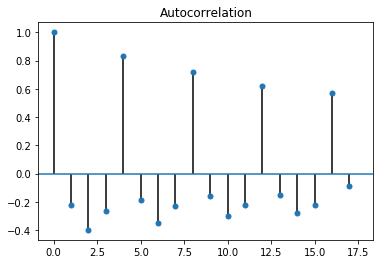

In [72]:
# Plot the acf function
plot_acf(HRB, alpha=1)
plt.show();

Notice the strong positive autocorrelation at lags 4, 8, 12, 16,20, ...

## Are We Confident This Stock is Mean Reverting?

You saw that the autocorrelation of MSFT's weekly stock returns was `-0.16`. That autocorrelation seems large, but is it **statistically significant**? `In other words, can you say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero?` And are there any autocorrelations at other lags that are significantly different from zero?

Even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is 1/N‾‾√ where N is the number of observations, so if N=100, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is ±1.96/N‾‾√. This approximation only holds when the true autocorrelations are all zero.

You will compute the actual and approximate confidence interval for the ACF, and compare it to the lag-one autocorrelation of -0.16 from the last chapter. The weekly returns of Microsoft is pre-loaded in a DataFrame called returns.

In [ ]:
---
<a id='s8'></a>

In [ ]:
<img src="images/ts_002.svg" alt="" style="width: 400px;"/>